In [4]:
#import library 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import datetime
import cv2
from tqdm import tqdm_notebook, tnrange, tqdm
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
from tensorflow import keras
from tensorflow.keras import layers, activations, metrics



In [5]:
image_masks = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_files = [i.replace('_mask','') for i in image_masks]

print(image_files[:1])
print(image_masks[:1])
print(len(image_files))
print(len(image_masks))


['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif']
3929
3929


In [6]:
def plot_image(image, mask):
    plt.figure(figsize=(7, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

In [7]:
def to_plot_one_image(path):
    img = cv2.imread(path)
    return img

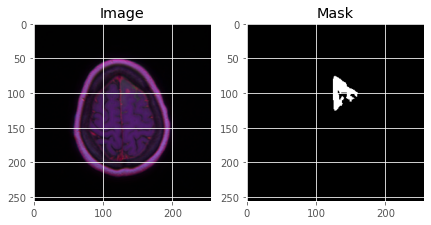

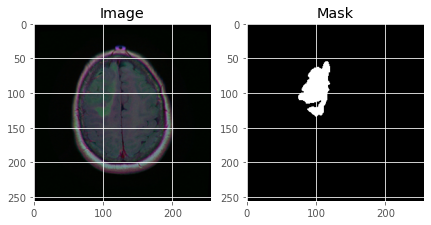

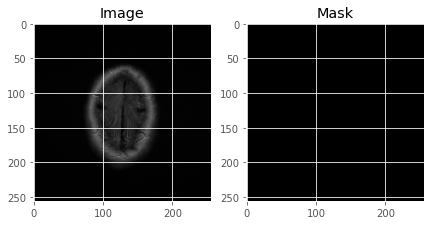

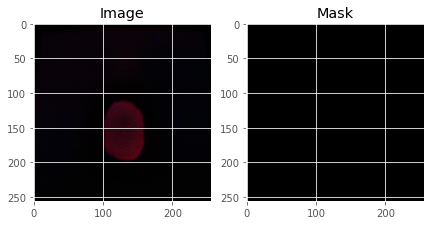

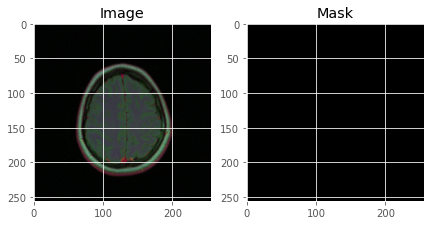

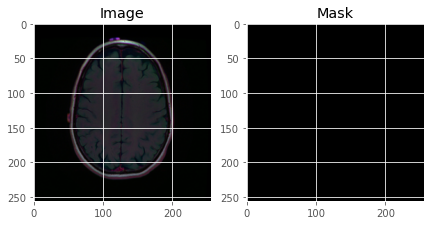

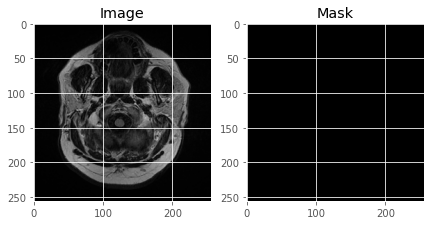

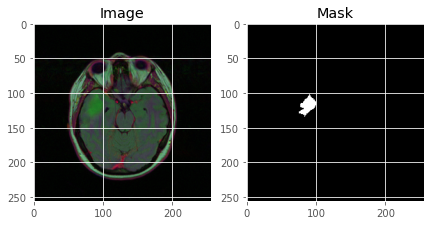

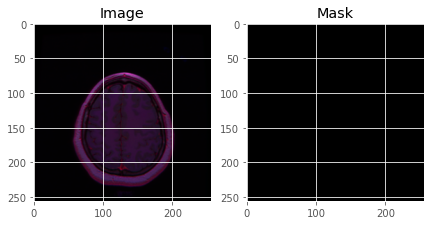

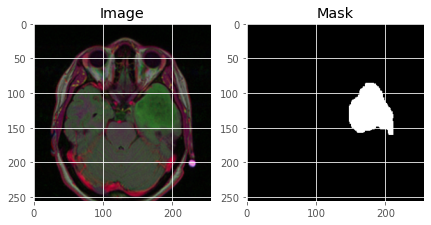

In [8]:
l = [random.randint(0,1000) for _ in range(10)]

for i in l:
    plot_image(to_plot_one_image(image_files[i]), to_plot_one_image(image_masks[i]))

In [9]:
def split_train_test():

    mri = pd.DataFrame(data = {"filename" : image_files, 
                                "mask"    : image_masks}
                       )
    train, test       = train_test_split(mri, test_size = 0.1)
    train, validation = train_test_split(train, test_size = 0.2)
    
    return train, test, validation

train, validation, test = split_train_test()

display(train.values.shape)
display(test.values.shape)
display(validation.values.shape)

(2828, 2)

(708, 2)

(393, 2)

In [10]:

def train_generator(data_frame        : pd.DataFrame(),
                    batch_size        : int,
                    aug_dict          : dict(),
                    image_color_mode  = "rgb",
                    mask_color_mode   = "grayscale",
                    image_save_prefix = "image",
                    mask_save_prefix  = "mask",
                    save_to_dir       = None,
                    target_size       = (256, 256),
                    seed              = 1
                    ):
 


    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "filename",
                                                        class_mode   = None,
                                                        color_mode   = image_color_mode,
                                                        target_size  = target_size,
                                                        batch_size   = batch_size,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed
                                                        )

    mask_generator = mask_datagen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "mask",
                                                        class_mode   = None,
                                                        color_mode   = mask_color_mode,
                                                        target_size  = target_size,
                                                        batch_size   = batch_size,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = mask_save_prefix,
                                                        seed         = seed
                                                      )

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [11]:
#loss function and metrics
smooth = 100

def dice_coef(y_true, y_pred):
    y_true_flattened = K.flatten(y_true)
    y_pred_flattened = K.flatten(y_pred)
    And = K.sum(y_true_flattened * y_pred_flattened)
    return((2 * And + smooth) / (K.sum(y_true_flattened) + K.sum(y_pred_flattened) + smooth))

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_true_flattened = K.flatten(y_true)
    y_pred_flattened = K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [12]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

In [13]:
def U_Net(input_size = (256, 256, 3)):
    
    
    inputs = Input(input_size)
    convolution_block_1 = Conv2D(filters   = 64,
                   kernel_size             = (3, 3),
                   padding                 = 'SAME')(inputs)
    
    
    batch_norm_1        = Activation('relu')(convolution_block_1)
    convolution_block_1 = Conv2D(64, (3, 3), padding = 'SAME')(batch_norm_1)
    batch_norm_1        = BatchNormalization(axis = 3)(convolution_block_1)
    batch_norm_1        = Activation('relu')(batch_norm_1)
    pooling_1           = MaxPooling2D(pool_size = (2, 2))(batch_norm_1)


    convolution_block_2 = Conv2D(128, (3, 3), padding = 'SAME')(pooling_1)
    bath_norm_2         = Activation('relu')(convolution_block_2)
    convolution_block_2 = Conv2D(128, (3, 3), padding = 'SAME')(bath_norm_2)
    bath_norm_2         = BatchNormalization(axis=3)(convolution_block_2)
    bath_norm_2         = Activation('relu')(bath_norm_2)
    pooling_2           = MaxPooling2D(pool_size=(2, 2))(bath_norm_2)



    convolution_block_3 = Conv2D(256, (3, 3), padding = 'SAME')(pooling_2)
    batch_norm_3        = Activation('relu')(convolution_block_3)
    convolution_block_3 = Conv2D(256, (3, 3), padding = 'SAME')(batch_norm_3)
    batch_norm_3        = BatchNormalization(axis = 3)(convolution_block_3)
    batch_norm_3        = Activation('relu')(batch_norm_3)
    pooling_3           = MaxPooling2D(pool_size = (2, 2))(batch_norm_3)


    convolution_block_4 = Conv2D(512, (3, 3), padding = 'SAME')(pooling_3)
    batch_norm_4        = Activation('relu')(convolution_block_4)
    convolution_block_4 = Conv2D(512, (3, 3), padding = 'SAME')(batch_norm_4)
    batch_norm_4        = BatchNormalization(axis = 3)(convolution_block_4)
    batch_norm_4        = Activation('relu')(batch_norm_4)
    pooling_4           = MaxPooling2D(pool_size = (2, 2))(batch_norm_4)


    convolution_block_5 = Conv2D(1024, (3, 3), padding = 'SAME')(pooling_4)
    batch_norm_5        = Activation('relu')(convolution_block_5)
    convolution_block_5 = Conv2D(1024, (3, 3), padding = 'SAME')(batch_norm_5)
    batch_norm_5        = BatchNormalization(axis=3)(convolution_block_5)
    batch_norm_5        = Activation('relu')(batch_norm_5)


    up_sampling_6       = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding = 'SAME')(batch_norm_5), convolution_block_4], axis=3)
    convolution_block_6 = Conv2D(512, (3, 3), padding='same')(up_sampling_6)
    batch_norm_6        = Activation('relu')(convolution_block_6)
    convolution_block_6 = Conv2D(512, (3, 3), padding='same')(batch_norm_6)
    batch_norm_6        = BatchNormalization(axis=3)(convolution_block_6)
    batch_norm_6        = Activation('relu')(batch_norm_6)



    up_sampling_7       = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding = 'SAME')(batch_norm_6), convolution_block_3], axis=3)
    convolution_block_7 = Conv2D(256, (3, 3), padding = 'SAME')(up_sampling_7)
    batch_norm_7        = Activation('relu')(convolution_block_7)
    convolution_block_7 = Conv2D(256, (3, 3), padding = 'SAME')(batch_norm_7)
    batch_norm_7        = BatchNormalization(axis = 3)(convolution_block_7)
    batch_norm_7        = Activation('relu')(batch_norm_7)


    up_sampling_8       = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(batch_norm_7), convolution_block_2], axis=3)
    convolution_block_8 = Conv2D(128, (3, 3), padding = 'SAME')(up_sampling_8)
    batch_norm_8        = Activation('relu')(convolution_block_8)
    convolution_block_8 = Conv2D(128, (3, 3), padding = 'SAME')(batch_norm_8)
    batch_norm_8        = BatchNormalization(axis = 3)(convolution_block_8)
    batch_norm_8        = Activation('relu')(batch_norm_8)


    up_sampling_9       = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'SAME')(batch_norm_8), convolution_block_1], axis=3)
    convolution_block_9 = Conv2D(64, (3, 3), padding = 'SAME')(up_sampling_9)
    batch_norm_9        = Activation('relu')(convolution_block_9)
    convolution_block_9 = Conv2D(64, (3, 3), padding = 'SAME')(batch_norm_9)
    batch_norm_9        = BatchNormalization(axis = 3)(convolution_block_9)
    batch_norm_9        = Activation('relu')(batch_norm_9)

    convolution_block_10 = Conv2D(1, (1, 1), activation = 'sigmoid')(batch_norm_9)

    return Model(inputs = [inputs], outputs = [convolution_block_10])

In [14]:
model = U_Net()
#model.summary()

2023-02-13 17:50:21.386279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 17:50:21.486769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 17:50:21.487580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 17:50:21.488786: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
EPOCHS          = 25
BATCH_SIZE      = 32
learning_rate   = 1e-4

In [16]:
train_generator_args = dict(rotation_range         = 0.2,
                            width_shift_range      = 0.05,
                            height_shift_range     = 0.05,
                            shear_range            = 0.05,
                            zoom_range             = 0.05,
                            horizontal_flip        = True,
                            fill_mode              = 'nearest',
                            )

train_gen = train_generator(train,
                            BATCH_SIZE,
                            train_generator_args,
                            target_size = (IMG_HEIGHT, IMG_WIDTH))
    
test_gener = train_generator(validation,
                             BATCH_SIZE,
                             dict(),
                             target_size = (IMG_HEIGHT, IMG_WIDTH))
    
model = U_Net(input_size=(IMG_HEIGHT, IMG_WIDTH, 3))

decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate  = learning_rate,
                  beta_1  = 0.9, 
                  beta_2  = 0.999,
                  epsilon = None,
                  decay   = decay_rate, 
                  amsgrad = False)

model.compile(optimizer = opt, 
              loss      = dice_coef_loss,
              metrics   = ["binary_accuracy", iou, dice_coef])

callbacks = ModelCheckpoint('Unet_Brain_MRI_V2.hdf5', 
                            verbose        = 1, 
                            save_best_only = True)

training_log = TensorBoard(log_dir = 'training_logs/')

2023-02-13 17:50:35.416933: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-13 17:50:35.417524: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-13 17:50:35.419525: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-02-13 17:50:35.710265: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-13 17:50:35.710427: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [17]:
history = model.fit(train_gen,
                    steps_per_epoch  = len(train) / BATCH_SIZE, 
                    epochs           = EPOCHS, 
                    callbacks        = [callbacks, training_log],
                    validation_data  = test_gener,
                    validation_steps = len(validation) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.


2023-02-13 17:50:47.153177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2023-02-13 17:50:49.965953: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/88 [..............................] - ETA: 25:07 - loss: -0.0044 - binary_accuracy: 0.3087 - iou: 0.0023 - dice_coef: 0.0044

2023-02-13 17:51:04.480259: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-13 17:51:04.480307: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/88 [..............................] - ETA: 1:33 - loss: -0.0147 - binary_accuracy: 0.3481 - iou: 0.0075 - dice_coef: 0.0147 

2023-02-13 17:51:05.520980: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-13 17:51:05.522212: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-02-13 17:51:05.683080: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 637 callback api events and 632 activity events. 
2023-02-13 17:51:05.712653: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-13 17:51:05.749949: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/train/plugins/profile/2023_02_13_17_51_05

2023-02-13 17:51:05.767233: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/train/plugins/profile/2023_02_13_17_51_05/314e683e9a8b.trace.json.gz
2023-02-13 17:51:05.827534: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating director

89/88 [==============================] - ETA: 0s - loss: -0.1081 - binary_accuracy: 0.8944 - iou: 0.0585 - dice_coef: 0.1086Found 393 validated image filenames.
Found 393 validated image filenames.
88/88 [==============================] - 140s 1s/step - loss: -0.1081 - binary_accuracy: 0.8944 - iou: 0.0585 - dice_coef: 0.1086 - val_loss: -0.0222 - val_binary_accuracy: 0.9826 - val_iou: 0.0116 - val_dice_coef: 0.0228

Epoch 00001: val_loss improved from inf to -0.02215, saving model to Unet_Brain_MRI_V2.hdf5
Epoch 2/25
88/88 [==============================] - 84s 948ms/step - loss: -0.1920 - binary_accuracy: 0.9859 - iou: 0.1073 - dice_coef: 0.1916 - val_loss: -0.0276 - val_binary_accuracy: 0.9907 - val_iou: 0.0142 - val_dice_coef: 0.0276

Epoch 00002: val_loss improved from -0.02215 to -0.02765, saving model to Unet_Brain_MRI_V2.hdf5
Epoch 3/25
88/88 [==============================] - 82s 927ms/step - loss: -0.2350 - binary_accuracy: 0.9893 - iou: 0.1344 - dice_coef: 0.2340 - val_loss:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fisize" which is no longer supported as of 3.3 and will become an error in 3.6


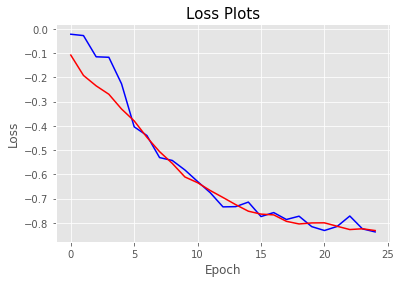

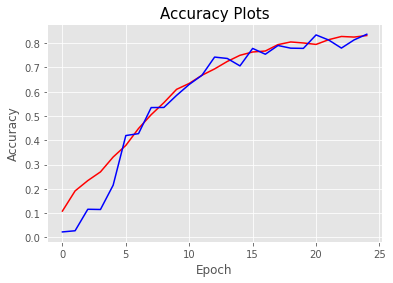

In [19]:
def plot_loss_accuracy():

    a = history.history

    list_traindice    = a['dice_coef']
    list_testdice     = a['val_dice_coef']

    list_trainjaccard = a['iou']
    list_testjaccard  = a['val_iou']

    list_trainloss    = a['loss']
    list_testloss     = a['val_loss']
    
    plt.figure(1)
    plt.plot(list_testloss, 'b-')
    plt.plot(list_trainloss,'r-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plots', fontsize = 15)
    plt.savefig("Loss Plots.jpg",figsize=(8,8))
    
    plt.figure(2)
    plt.plot(list_traindice, 'r-')
    plt.plot(list_testdice, 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plots', fontsize = 15)
    plt.savefig("Accuracy Graphs.jpg",fisize=(8,8))
    plt.show()
    
plot_loss_accuracy()

In [20]:
test_gen = train_generator(test,
                           BATCH_SIZE,
                           dict(),
                           target_size = (IMG_HEIGHT, IMG_WIDTH))

results = model.evaluate(test_gen, 
                         steps = len(test) / BATCH_SIZE)

print("Test loss: ",            results[0])
print("Test IOU: ",             results[1])
print("Test Dice Coefficent: ", results[2])

Found 708 validated image filenames.
Found 708 validated image filenames.
22/22 [==============================] - 12s 565ms/step - loss: -0.8216 - binary_accuracy: 0.9970 - iou: 0.6901 - dice_coef: 0.8053
Test loss:  -0.8215628862380981
Test IOU:  0.9970189332962036
Test Dice Coefficent:  0.6900763511657715


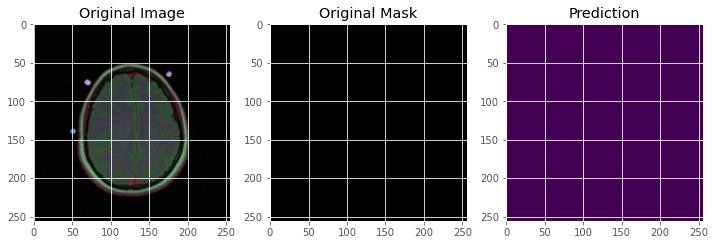

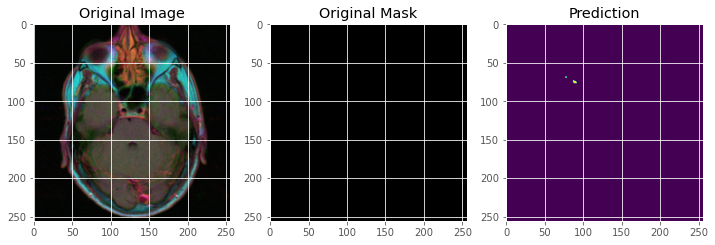

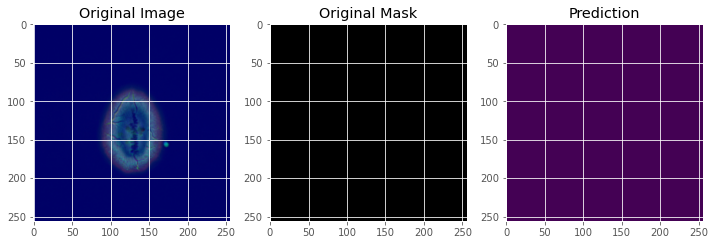

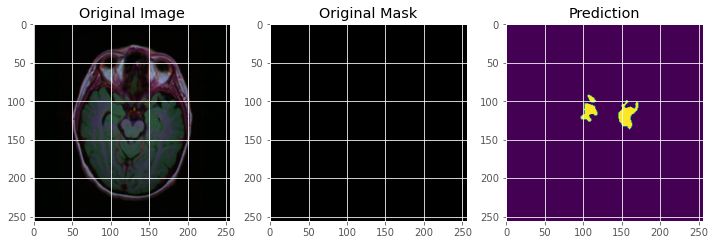

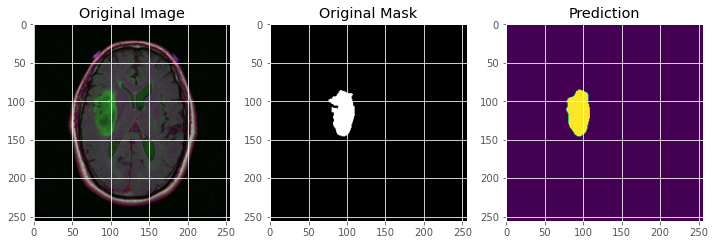

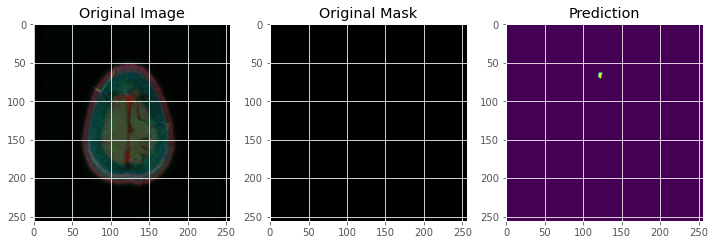

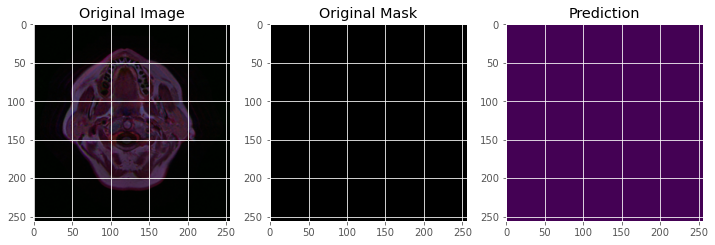

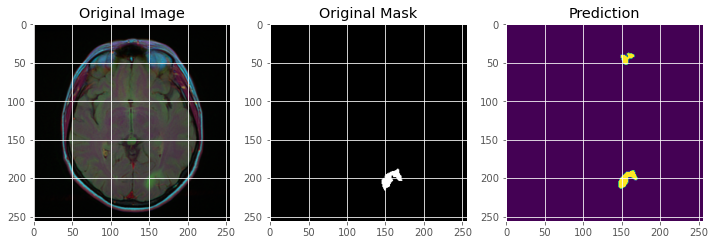

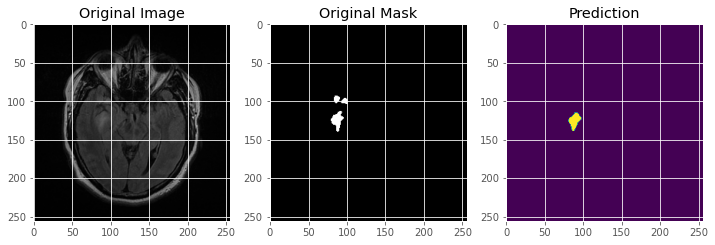

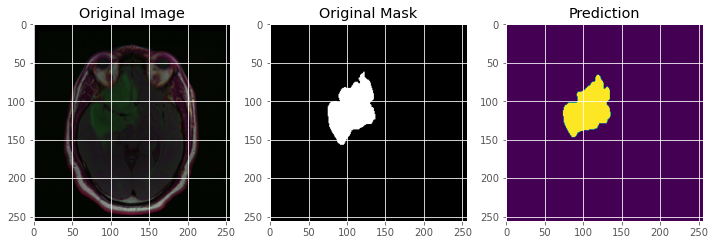

In [25]:

def plot_prediction(number_of_images : int = None):

    for i in range(number_of_images):

        index = np.random.randint(1, len(test.index))
        img = cv2.imread(test['filename'].iloc[index])
        img = cv2.resize(img,(IMG_HEIGHT, IMG_WIDTH))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred = model.predict(img)

        plt.figure(figsize = (12, 12))
        plt.subplot(1, 3 ,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(cv2.imread(test['mask'].iloc[index])))
        plt.title('Original Mask')
    
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

plot_prediction(10)

# Second Method

In [26]:

root_directory = '../input/lgg-mri-segmentation/kaggle_3m'

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root_directory)):
        path = os.path.join(root_directory, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels

def read_images(paths, tipefile):
    images = []
    
    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)    
    else:
        
        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)
    
    imgs1 = np.array(images)
    
    return imgs1
    
#  
def read_image(path):
    
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [27]:
imgs, labels = get_images_path()
images = read_images(imgs, 'images')
masks = read_images(labels, 'masks')

100%|██████████| 3929/3929 [00:05<00:00, 670.47it/s]


In [28]:
def plot_image(image, mask):
    plt.figure(figsize=(7, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

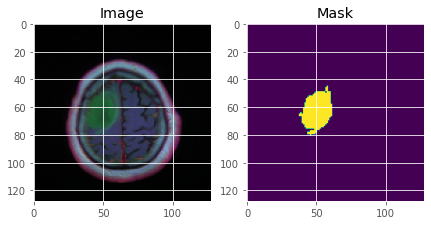

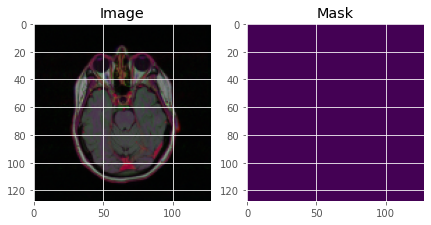

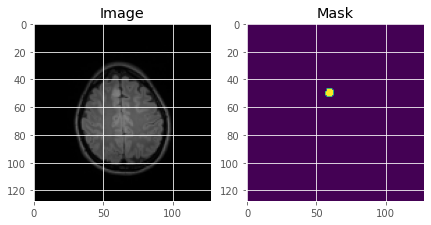

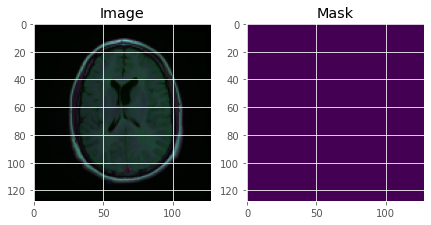

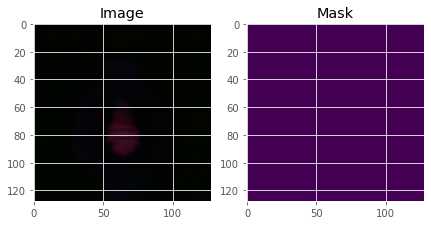

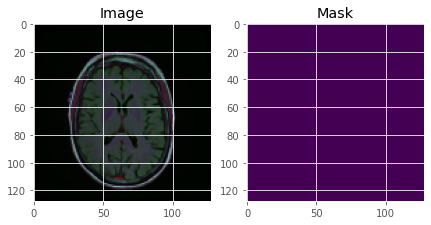

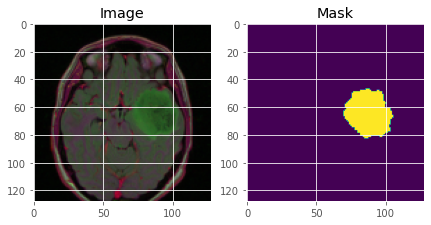

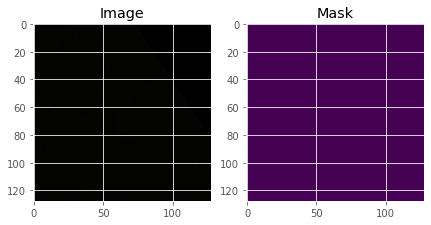

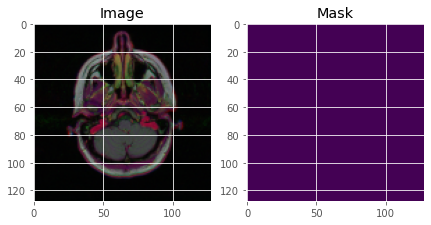

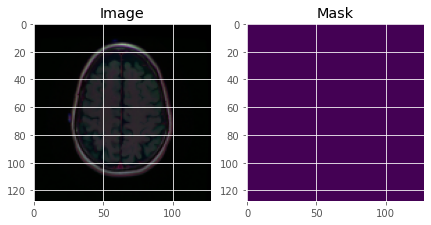

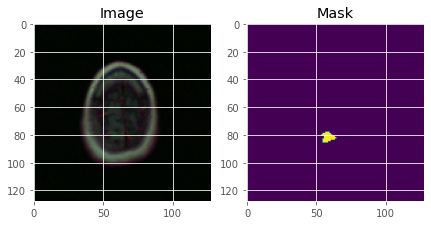

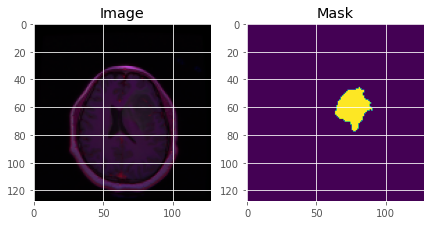

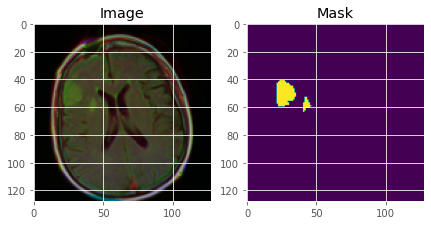

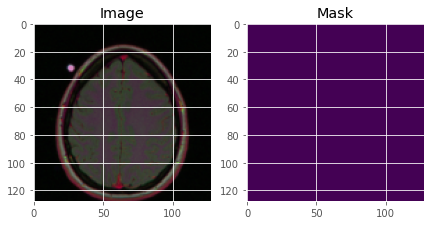

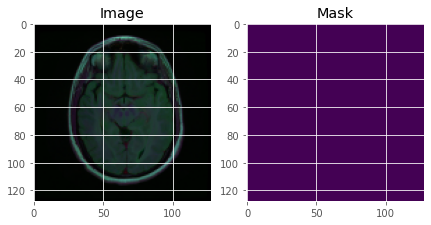

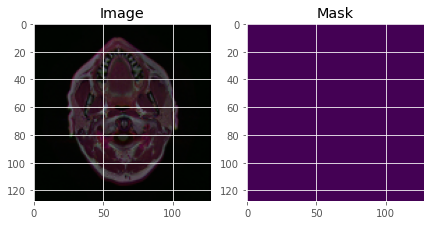

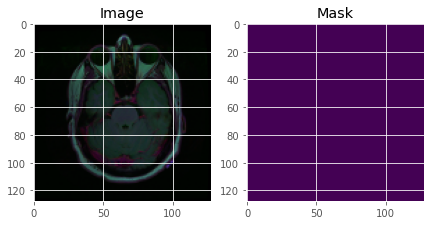

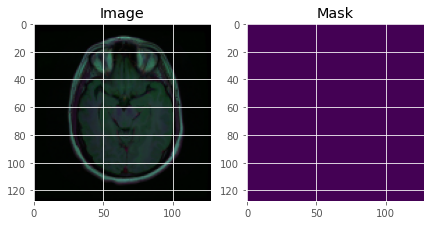

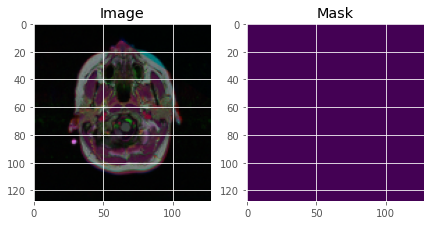

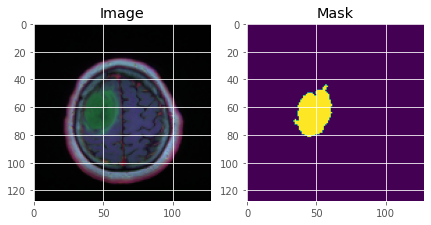

In [29]:
l = [random.randint(0,1000) for _ in range(20)]

for i in l:
    plot_image(images[i], masks[i])

In [30]:
instance = []
for i in range(masks.shape[0]):
    
    if sum(sum(masks[i])) == 0:
        instance.append('neg')
    else:
        instance.append('pos')


In [32]:
count = 0
for i in range(len(instance)):
    if instance[i] == 'pos':
        count += 1
print('Positive Case: ', count)

count = 0
for i in range(len(instance)):
    if instance[i] == 'neg':
        count += 1
print('Negative case: ', count)

Positive Case:  1373
Negative case:  2556


In [34]:
n = images.shape[0]

images_pos = []
masks_pos = []

for i in range(n):
    if instance[i] == 'pos':
        images_pos.append(images[i])
        masks_pos.append(masks[i])
        
images_pos = np.array(images_pos)
masks_pos = np.array(masks_pos)

print('Image Shape',images_pos.shape)
print('Mask shape ',masks_pos.shape)


Image Shape (1373, 128, 128, 3)
Mask shape  (1373, 128, 128, 1)


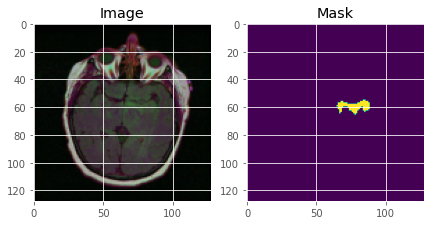

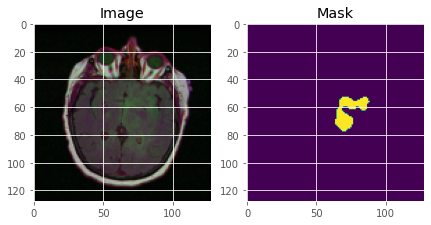

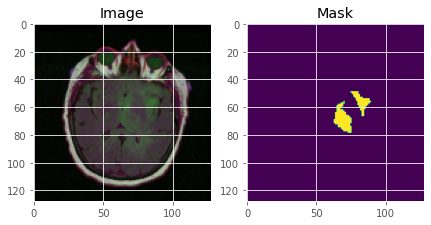

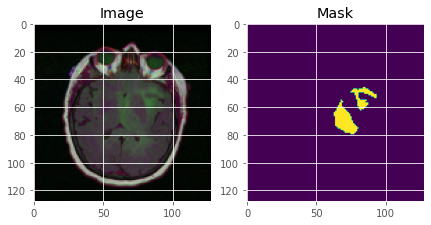

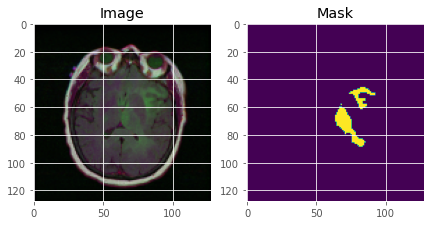

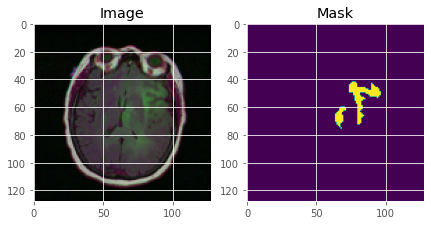

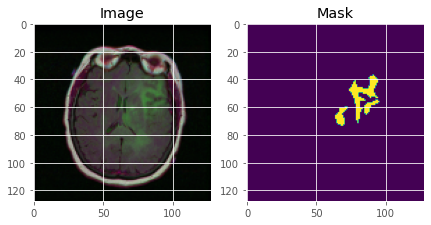

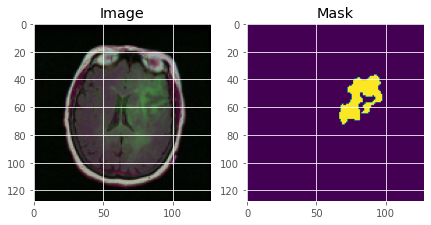

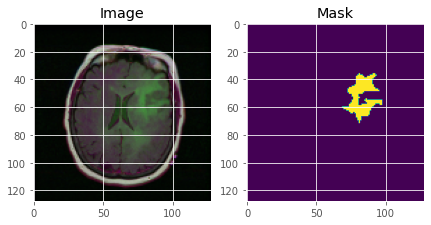

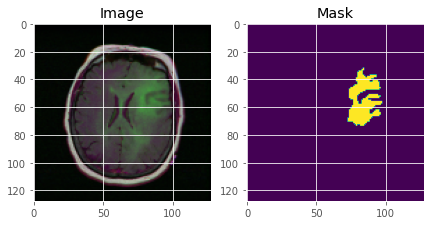

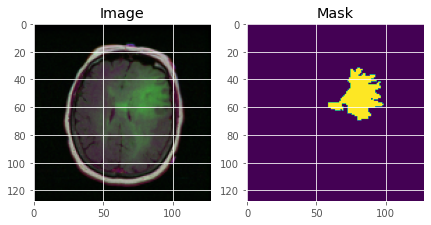

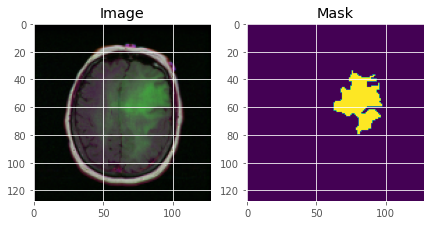

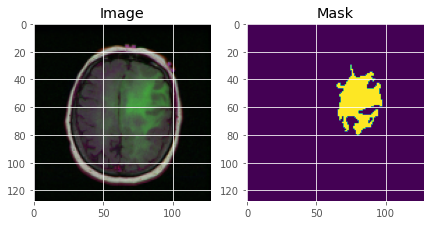

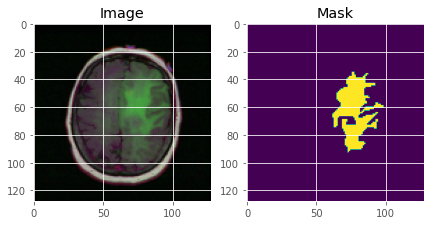

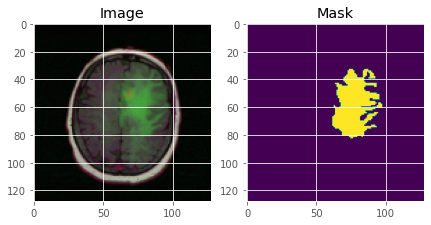

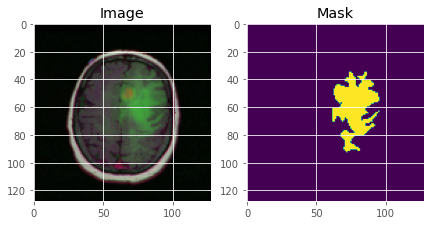

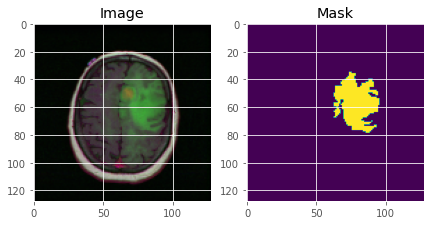

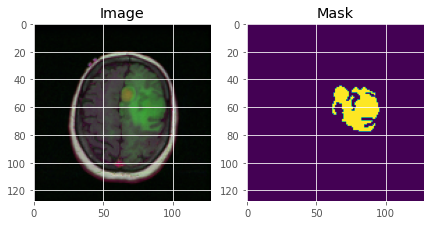

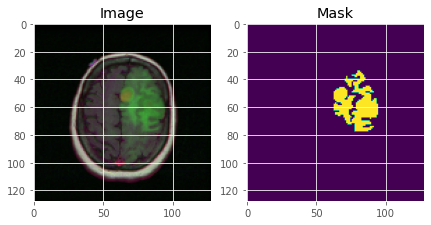

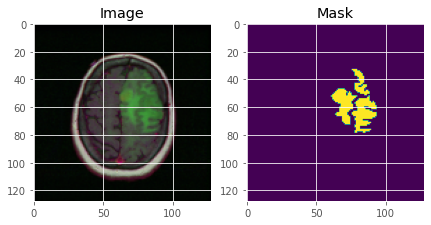

In [35]:
for i in range(20):
    plot_image(images_pos[i],masks_pos[i])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(images_pos, masks_pos, test_size = .25, random_state = 288)

In [37]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .50, random_state = 288)

In [38]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)
print('\n')
print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (1029, 128, 128, 3)
X_val shape:    (172, 128, 128, 3)
X_test shape:   (172, 128, 128, 3)


########## Masks ##########
y_train shape:  (1029, 128, 128, 1)
y_val shape:    (172, 128, 128, 1)
y_test shape:   (172, 128, 128, 1)


In [42]:
def create_conv_block(input_tensor, num_filters):
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [43]:
def create_unet(input_shape, num_filters=16, dropout=0.1):
    # Encoder
    
    c1 = create_conv_block(input_shape, num_filters * 1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = create_conv_block(p1, num_filters * 2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = create_conv_block(p2, num_filters * 4)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = create_conv_block(p3, num_filters * 8)
    
    # Decoder
    
    u5 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c3])
    u5 = tf.keras.layers.Dropout(dropout)(u5)
    c5 = create_conv_block(u5, num_filters*4)
    
    u6 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = create_conv_block(u6, num_filters*2)
    
    u7 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = create_conv_block(u7, num_filters*1)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = tf.keras.Model(inputs = [input_shape], outputs = [output])
    
    return model 

In [44]:
inputs = tf.keras.layers.Input((128, 128, 3))
model = create_unet(inputs)

In [45]:
model.compile(optimizer='Adam', loss      = dice_coef_loss, 
              metrics   = ["binary_accuracy", iou, dice_coef])

In [47]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)]

In [48]:
model_history = model.fit(X_train, 
                          y_train,
                          verbose = 1,
                          epochs = 100,
                          validation_data = (X_val, y_val),
                          callbacks = my_callbacks)

Epoch 1/100
33/33 [==============================] - 5s 89ms/step - loss: -0.1979 - binary_accuracy: 0.8898 - iou: 0.1134 - dice_coef: 0.2007 - val_loss: -0.1284 - val_binary_accuracy: 0.8382 - val_iou: 0.0696 - val_dice_coef: 0.1294
Epoch 2/100
33/33 [==============================] - 2s 65ms/step - loss: -0.3708 - binary_accuracy: 0.9721 - iou: 0.2337 - dice_coef: 0.3754 - val_loss: -0.1488 - val_binary_accuracy: 0.9047 - val_iou: 0.0839 - val_dice_coef: 0.1535
Epoch 3/100
33/33 [==============================] - 2s 66ms/step - loss: -0.4970 - binary_accuracy: 0.9820 - iou: 0.3366 - dice_coef: 0.5008 - val_loss: -0.1776 - val_binary_accuracy: 0.9002 - val_iou: 0.1004 - val_dice_coef: 0.1810
Epoch 4/100
33/33 [==============================] - 2s 66ms/step - loss: -0.6003 - binary_accuracy: 0.9851 - iou: 0.4342 - dice_coef: 0.6024 - val_loss: -0.2725 - val_binary_accuracy: 0.9687 - val_iou: 0.1687 - val_dice_coef: 0.2841
Epoch 5/100
33/33 [==============================] - 2s 65ms/ste

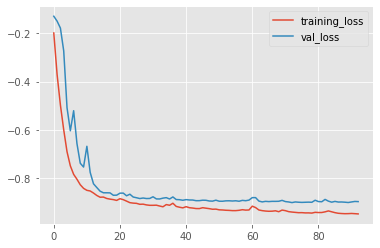

In [49]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fisize" which is no longer supported as of 3.3 and will become an error in 3.6


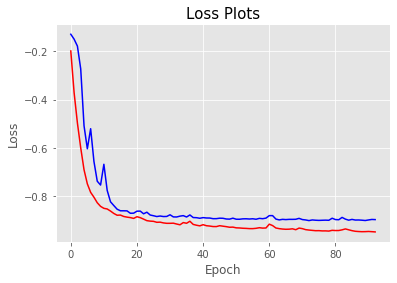

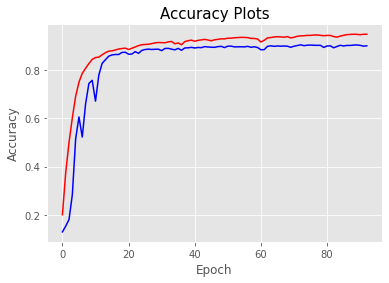

In [50]:
def plot_loss_accuracy():

    a = model_history.history

    list_traindice    = a['dice_coef']
    list_testdice     = a['val_dice_coef']

    list_trainjaccard = a['iou']
    list_testjaccard  = a['val_iou']

    list_trainloss    = a['loss']
    list_testloss     = a['val_loss']
    
    plt.figure(1)
    plt.plot(list_testloss, 'b-')
    plt.plot(list_trainloss,'r-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plots', fontsize = 15)
    plt.savefig("Loss Plots.jpg",figsize=(8,8))
    
    plt.figure(2)
    plt.plot(list_traindice, 'r-')
    plt.plot(list_testdice, 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plots', fontsize = 15)
    plt.savefig("Accuracy Graphs.jpg",fisize=(8,8))
    plt.show()
    
plot_loss_accuracy()

In [51]:
def predict_test_samples(X_test, y_test, model):
    test_images = np.array(X_test)

    predictions = model.predict(test_images)

    return predictions, test_images, y_test

In [52]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(X_test, y_test, model)

In [53]:
def plot_images(test_image, predicted_maks, ground_truth):
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_maks)
    plt.title('Predicted mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title('Ground truth mask')

In [54]:
results = model.evaluate(X_test, y_test,
                         steps = len(test) / BATCH_SIZE)

print("Test loss: ",            results[0])
print("Test IOU: ",             results[1])
print("Test Dice Coefficent: ", results[2])

22/22 [==============================] - 0s 14ms/step - loss: -0.8892 - binary_accuracy: 0.9941 - iou: 0.8077 - dice_coef: 0.8895
Test loss:  -0.8891821503639221
Test IOU:  0.9940625429153442
Test Dice Coefficent:  0.8076551556587219


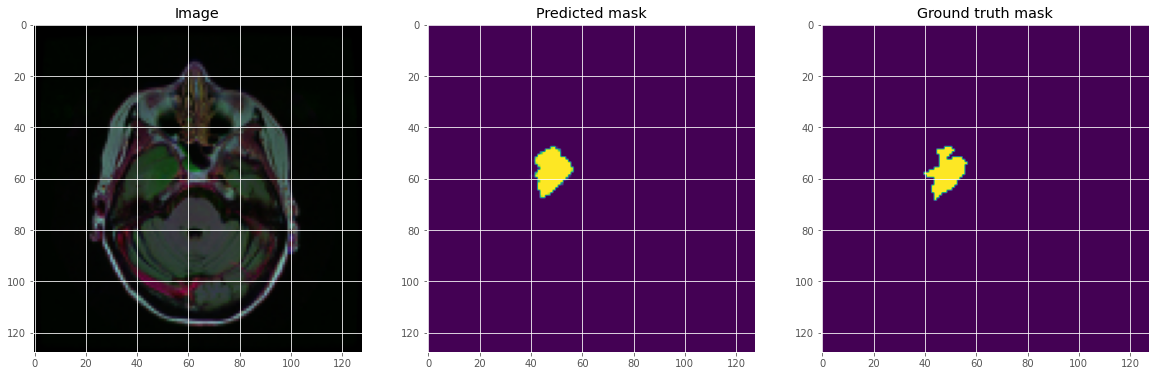

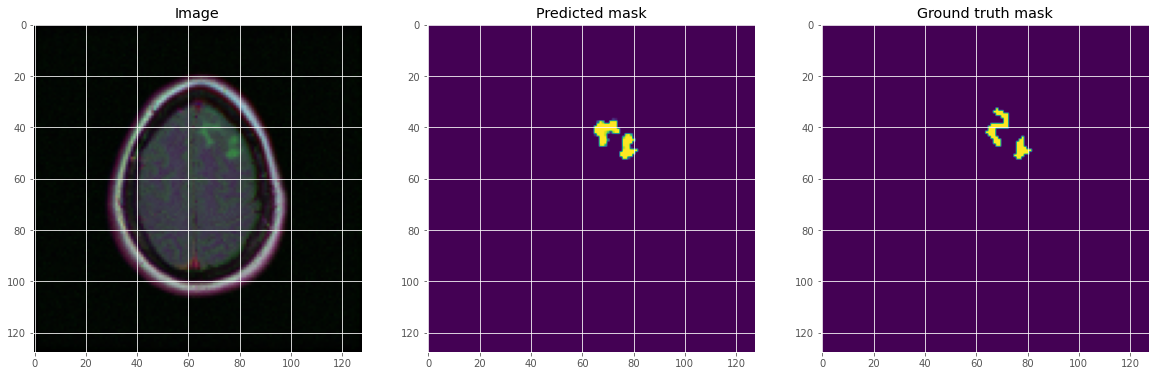

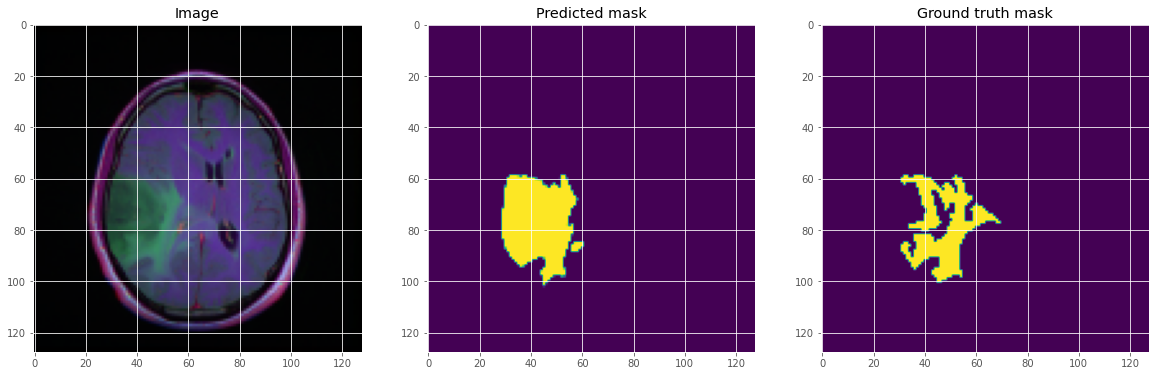

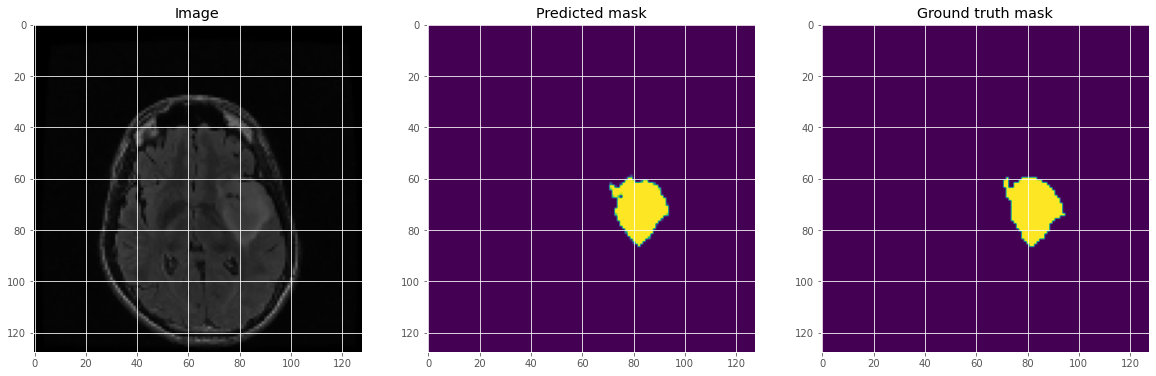

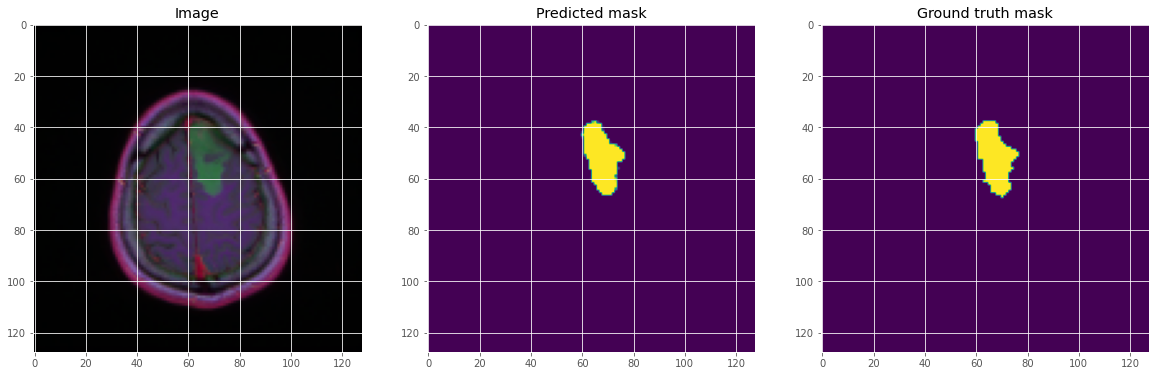

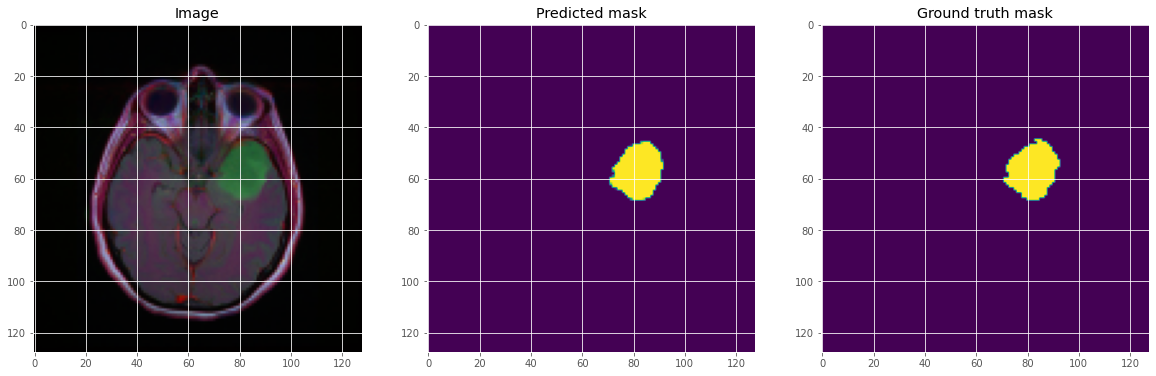

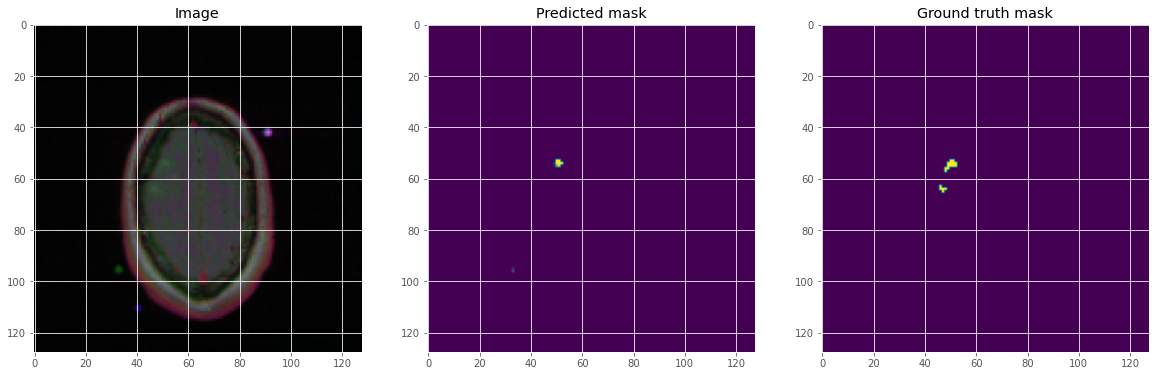

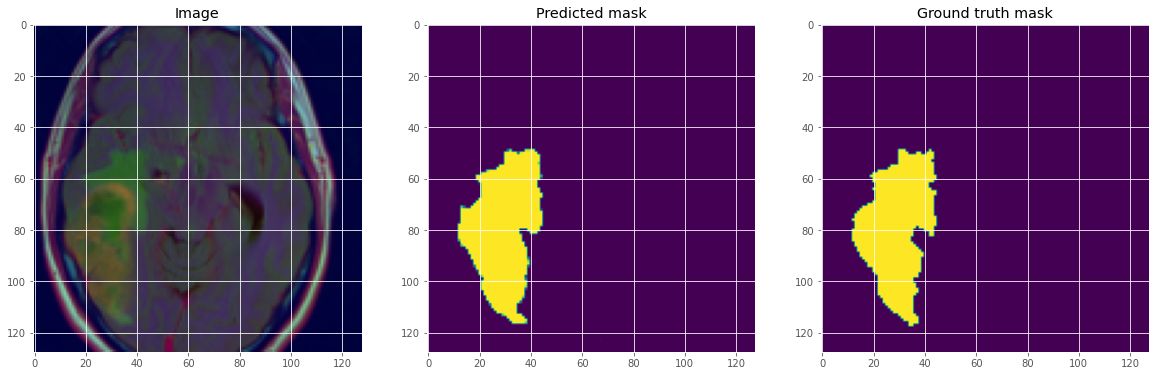

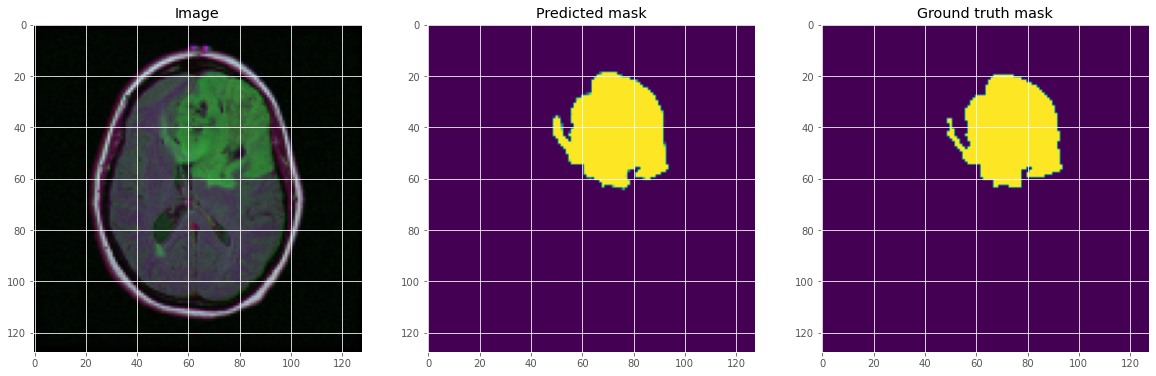

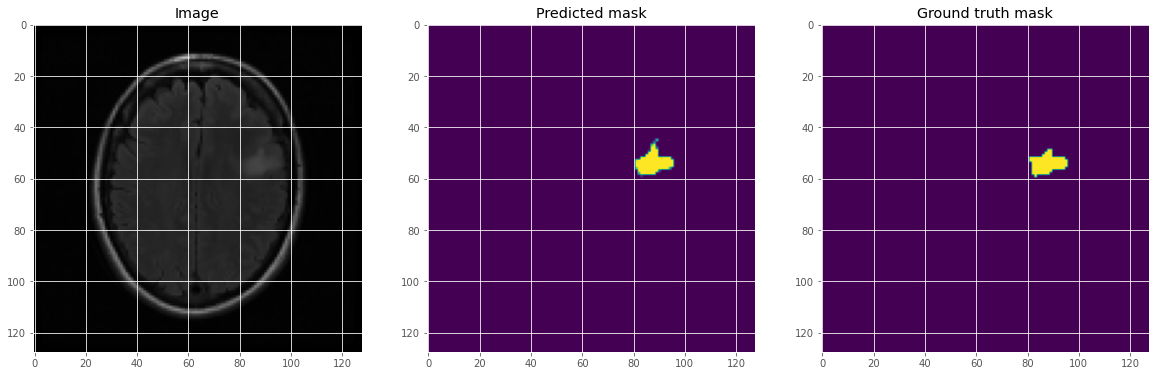

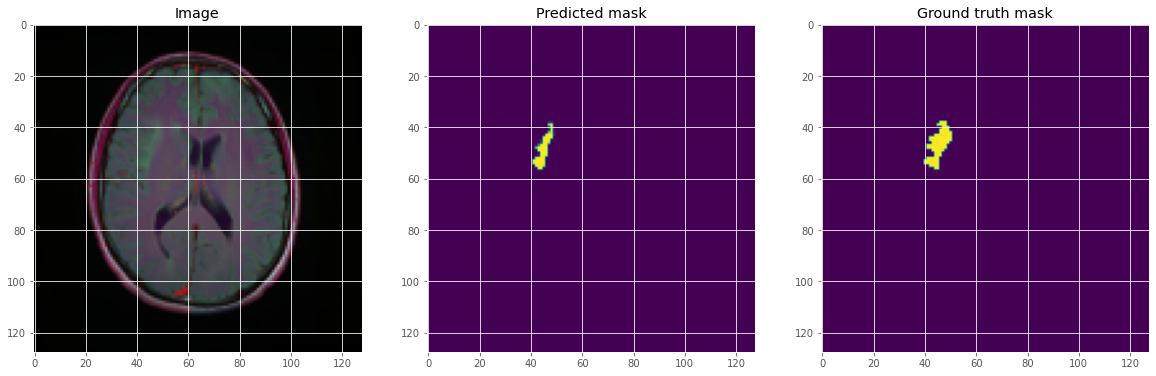

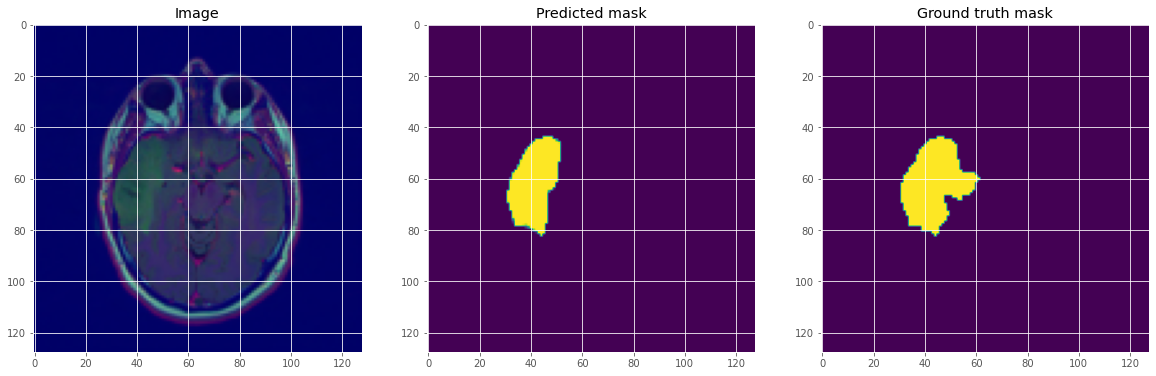

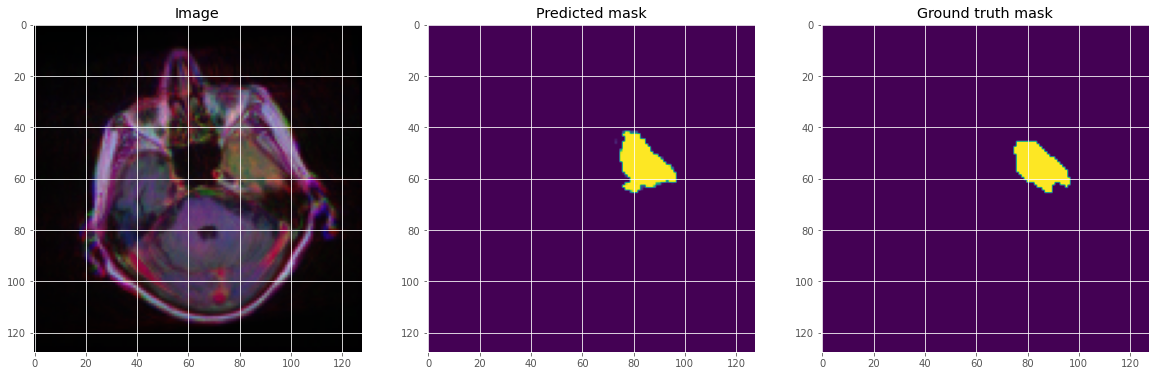

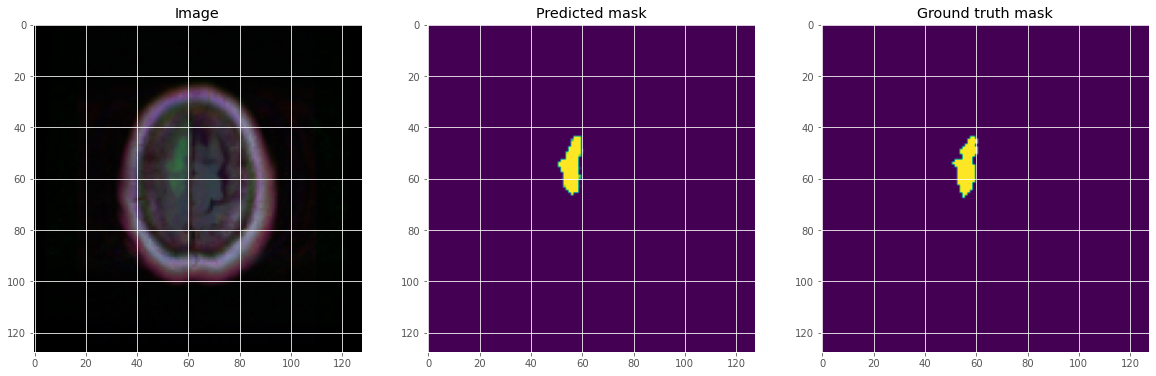

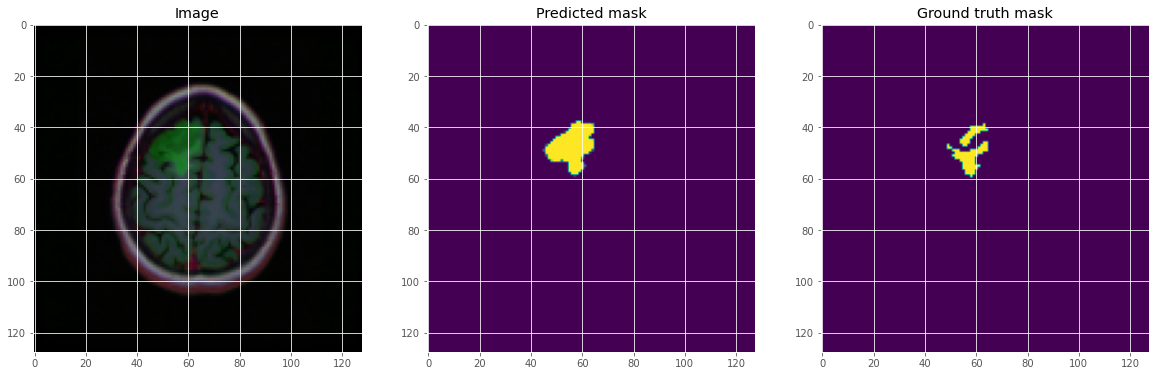

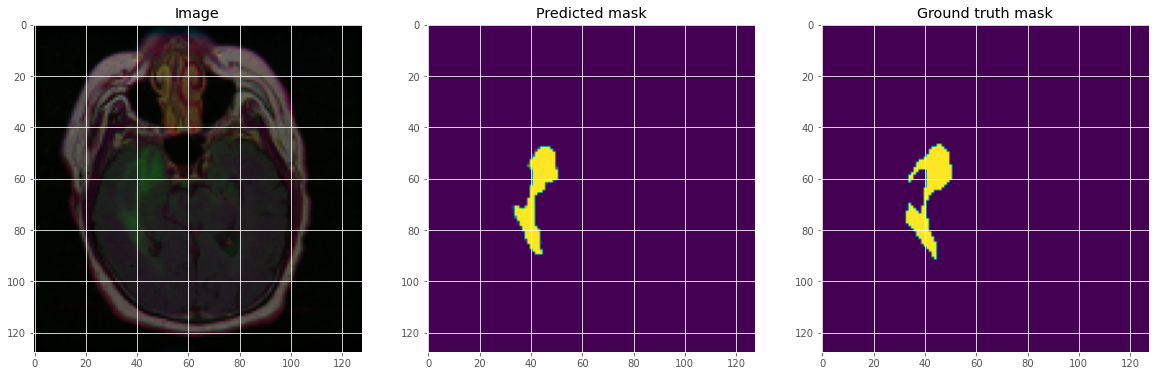

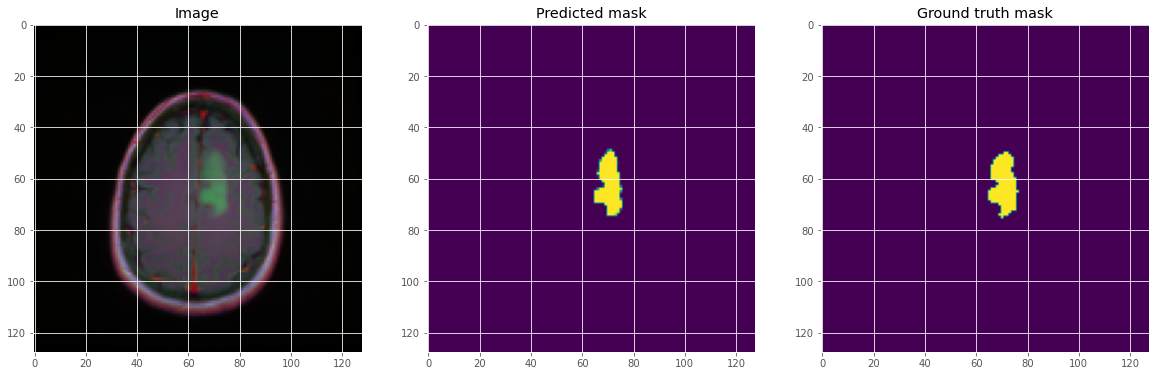

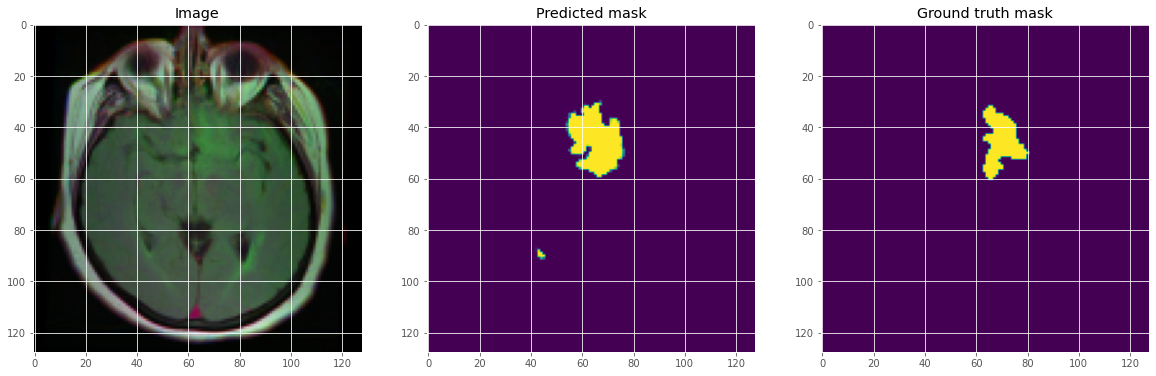

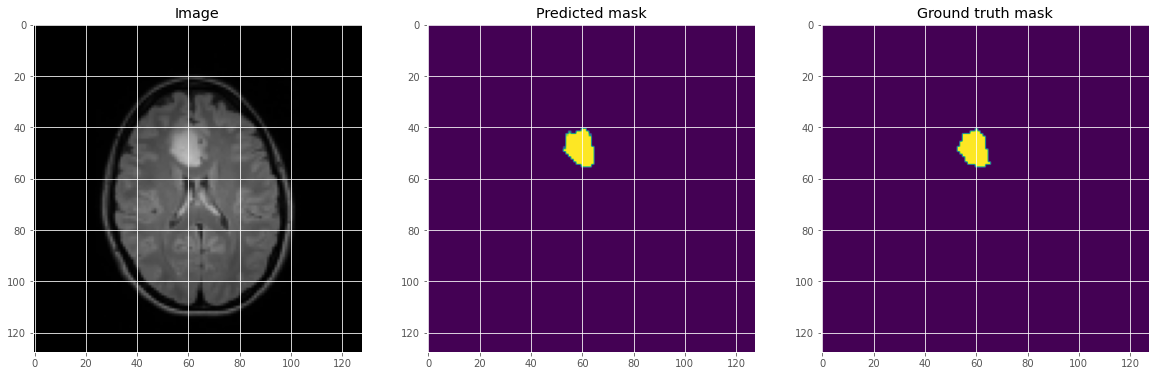

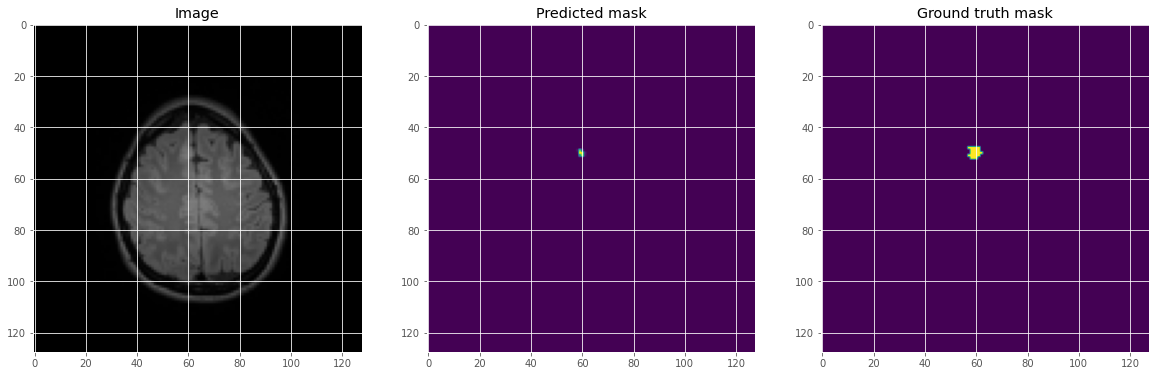

In [55]:
for idx in range(0, 20):
    plot_images(test_images[idx], predicted_masks[idx], ground_truth_masks[idx])